# Population by commune

In [2]:
from pynsee.geodata import *

import math
import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

Previously saved data used
/home/coder/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data

Previously saved data used
/home/coder/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Set update=True to get the most up-to-date data

In [5]:
mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

mapcom = mapcom.to_crs(epsg=3035)
mapcom["area"] = mapcom['geometry'].area / 10**6
mapcom = mapcom.to_crs(epsg=3857)

mapcom['REF_AREA'] = 'D' + mapcom['insee_dep']
mapcom['density'] = mapcom['population'] / mapcom['area'] 

In [6]:
mapcom = GeoFrDataFrame(mapcom)
mapcom = mapcom.translate(departement = ['971', '972', '974', '973', '976'], 
                          factor = [1.5, 1.5, 1.5, 0.35, 1.5])

In [7]:
mapcom = mapcom.zoom(departement = ["75","92", "93", "91", "77", "78", "95", "94"],
                     factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))
mapcom

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox,crs,area,REF_AREA,density
0,COMMUNE_0000001169858694,Vieux-Fort,VIEUX-FORT,97133,Commune simple,1842,20,1,971,01,249710070,(POLYGON ((-747283.1185092311 6261545.36891737...,"[-6869541.41965288, 1798515.90349095, -6865707...",EPSG:3857,7.341681,D971,250.896219
1,COMMUNE_0000001169858679,Gourbeyre,GOURBEYRE,97109,Commune simple,7760,20,1,971,01,249710070,(POLYGON ((-738879.3381710667 6274006.25751269...,"[-6870966.31496182, 1801134.91008462, -6863418...",EPSG:3857,22.633721,D971,342.851266
2,COMMUNE_0000001169858695,Terre-de-Bas,TERRE-DE-BAS,97130,Commune simple,975,20,1,971,01,249710070,(POLYGON ((-732640.2300285902 6241062.13889929...,"[-6862954.7864924, 1786156.37066403, -6858885....",EPSG:3857,6.773555,D971,143.942134
3,COMMUNE_0000001169858666,Saint-Louis,SAINT-LOUIS,97126,Commune simple,2397,10,2,971,01,249710047,(POLYGON ((-666227.3979513757 6260492.33968821...,"[-6826466.0858777, 1795861.91154973, -6815342....",EPSG:3857,57.347426,D971,41.797865
4,COMMUNE_0000001169858687,Trois-Rivières,TROIS-RIVIERES,97132,Commune simple,7862,20,1,971,01,249710070,(POLYGON ((-731349.3494039718 6264256.75864978...,"[-6866676.25158807, 1799264.47940223, -6858867...",EPSG:3857,31.216141,D971,251.856882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36218,COMMUNE_0000000009734468,Vendrest,VENDREST,77490,Commune simple,696,06,1,77,11,247700065,(POLYGON ((-361891.4578667551 6622609.17197233...,"[341330.98775089, 6278825.84895588, 350904.847...",EPSG:3857,17.692283,D77,39.339185
36219,COMMUNE_0000000009734980,Ocquerre,OCQUERRE,77343,Commune simple,392,06,1,77,11,247700065,(POLYGON ((-364995.7685882247 6618752.63454925...,"[337038.06572493, 6277160.42905055, 343734.463...",EPSG:3857,10.165914,D77,38.560232
36220,COMMUNE_0000000009734981,Mary-sur-Marne,MARY-SUR-MARNE,77280,Commune simple,1114,06,1,77,11,247700065,(POLYGON ((-373298.8244794502 6618451.96946652...,"[335409.61945441, 6276030.38893351, 339858.746...",EPSG:3857,2.233051,D77,498.869046
36221,COMMUNE_0000000009734470,Dhuisy,DHUISY,77157,Commune simple,311,06,1,77,11,247700065,(POLYGON ((-351625.7665562249 6618194.16540073...,"[349321.12599156, 6276714.73065152, 355190.946...",EPSG:3857,8.149347,D77,38.162568


In [8]:
mapplot = gpd.GeoDataFrame(mapcom)
mapplot.loc[mapplot.density < 40, 'range'] = "< 40"
mapplot.loc[mapplot.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 80, 100, 120, 150, 200, 250, 400, 600, 1000, 2000, 5000, 10000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    mapplot.loc[(mapplot.density >= min_range) & (mapplot.density < max_range), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

mapplot['range'] = mapplot['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))  

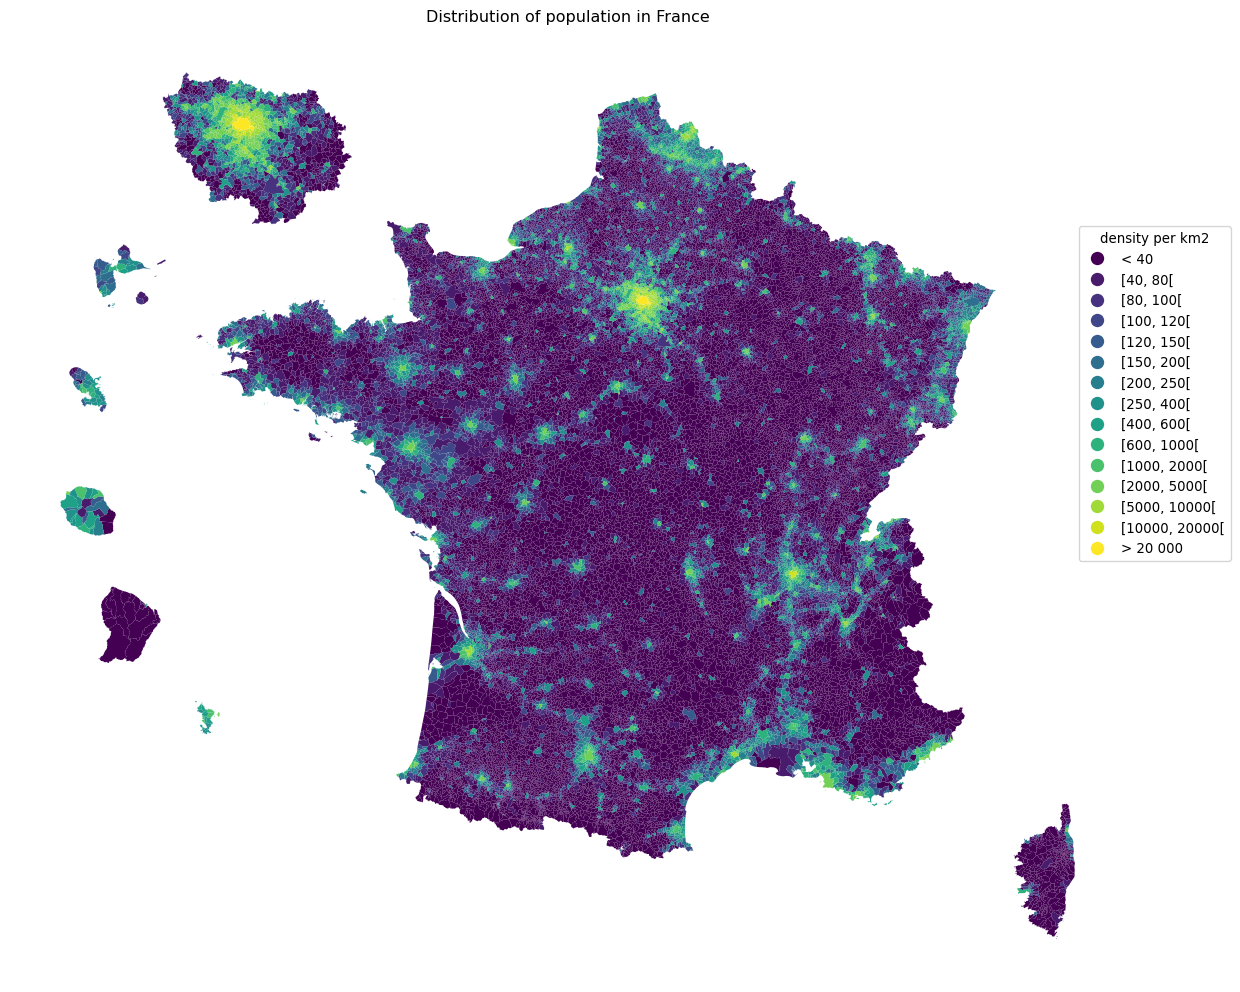

In [9]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
mapplot.plot(column='range', cmap=cm.viridis,
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in France')
plt.show()

fig.savefig('pop_france.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)